In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import emcee
import csv
import multiprocess as mp
import os

os.environ["OMP_NUM_THREADS"] = "1"

### Leitura dos dados

 Informações:
 
 -Os dados estão em formato diário, não acumulado.

 -As mortes são subgrupo dos hospitalizados.

 -O index onde termina 2020 é 264
 
 -O index onde acaba 2021 é 627

 -O início da vacinação se dá em 18/01/2021 (index 282)



In [2]:
#Importando e separando os dados

df = pd.read_csv("cleanned_data.csv")
date = df.Date.values

daily_death = df.mortes.values
daily_death_v = df.mortes_vacinados.values

daily_cases = df.casos.values
daily_cases_v = df.infectados_vacinados.values

daily_hosp = df.hospitalizados.values
daily_hosp_v = df.hospitalizados_vacinados.values

daily_vac = df.vacinados.values


#Aplicando a média móvel de 7 dias
# a = daily_vac
def media_movel(arr, janela):
    return np.convolve(arr, np.ones(janela) / janela, mode='valid')

daily_cases = media_movel(daily_cases,7)
daily_cases_v = media_movel(daily_cases_v,7)
daily_death = media_movel(daily_death,7)
daily_death_v = media_movel(daily_death_v,7)
daily_hosp = media_movel(daily_hosp,7)
daily_hosp_v = media_movel(daily_hosp_v,7)


#CORTANDO OS DADOS

daily_cases_1 = daily_cases[0:150]
daily_death_1 = daily_death[0:150]
daily_hosp_1 = daily_hosp[0:150]

daily_cases_2 = daily_cases[201:282]
daily_death_2  = daily_death[201:282]
daily_hosp_2 = daily_hosp[201:282]


### Fitting do modelo

#### Modelo 2020

In [3]:
N = 14136417
def model_2020(t, y,args):
    
    
    b0, b1, t1, delta, k, h, p, gamma_h, mu_h = args
    
    if t <= t1:
        beta = b0
    else:
        beta = b1
    # #parâmetros fixos
    gamma_s = 1/4
    gamma_a = 1/3.5
    
    phi = 0
    eps =0
    
    delta_av = 0
    delta_sv = 0

    gamma_s = 1/4
    gamma_a = 1/3.5

    gamma_av = 0
    gamma_sv = 0
    gamma_hv = 0
    mu_hv = 0
    
    k_v = 0
    p_v = 0
    h_v = 0
    
    S, E, V, Sv, Ev, Ia, Is, Iav, Isv, H, Hv, R, D, C, Nh, CHv, Cv = y
    
    tau = 0
    #suscetíveis e latentes
    dSdt = -beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - tau
    dVdt = tau - phi*V 
    dEdt = beta*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)*S/N - k*E
    dSvdt =  phi*V - (1-eps)*beta*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N
    dEvdt = ((1-eps)*beta*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv))/N - k_v*Ev
    
    #infectados
    dIadt = (1-p)*k*E - gamma_a*Ia
    dIsdt = p*k*E - gamma_s*Is
    dHdt = h*gamma_s*Is - gamma_h*H - mu_h*H
    
    #infectados vacinados
    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv
    dHvdt = h_v*gamma_sv*Isv - gamma_hv*Hv - mu_hv*Hv
    
    #recuperados
    dRdt = gamma_a*Ia + gamma_av*Iav + (1-h)*gamma_s*Is + (1-h_v)*gamma_sv*Isv + gamma_h*H + gamma_hv*Hv
    
    #Óbitos
    dDdt = mu_h*H + mu_hv*Hv
    
    #Curvas de crescimento
    dCdt = p*k*E #infectados sintomáticos
    dNHdt = h*gamma_s*Is #hospitalizados
    dCHVdt = h_v*gamma_sv*Isv #hospitalizados vacinados
    dCVdt = p_v*k_v*Ev #infectados vacinados
    
    return [dSdt, dEdt, dVdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, dHdt, dHvdt,dRdt,
             dDdt, dCdt, dNHdt, dCHVdt, dCVdt]

##### Parâmetros 2020

In [4]:

# parametros = []
# saida = []
# i=0
# while i<3:
    
#     intervals = np.array(   [ 
#                              [0, 2.], # b0
#                              [0, 2.], # b1
#                              [0, 60], # t1
#                              [0.1, 0.75], # delta
#                              [1/6, 1/5], # k
#                              [0.05, 0.25], # h
#                              [0.1, 0.5], # p
#                              [1/6, 1/3], # gamma_h
#                              [0.05, 0.3], # mu_h
#                              [1,100] # i0
#                            ])

#     def lnprior(theta):
#         b0, b1, t1, delta, k, h, p, gamma_h, mu_h, i0 = theta

#         if (    intervals[0,0]<   b0        < intervals[0,1]
#             and intervals[1,0]<   b1     < intervals[1,1]
#             and intervals[2,0]<   t1         < intervals[2,1]
#             and intervals[3,0]<   delta         < intervals[3,1]
#             and intervals[4,0]<   k         < intervals[4,1]
#             and intervals[5,0]<   h   < intervals[5,1]
#             and intervals[6,0]<   p      < intervals[6,1]
#             and intervals[7,0]<   gamma_h        < intervals[7,1]
#             and intervals[8,0]<   mu_h        < intervals[8,1]
#             and intervals[9,0]<   i0        < intervals[9,1]
#         ):
#             return 0.0
#         return -np.inf

#     def model(theta):
#         b0, b1, t1, delta, k, h, p, gamma_h, mu_h, i0 = theta
#         params =  b0, b1, t1, delta, k, h, p, gamma_h, mu_h
#         sol = solve_ivp(fun = model_2020, t_span = [0, len(daily_cases_1)], args=(params,),
#                         y0=[N-i0,0,0,0,0,0,i0,0,0,0,0,0,0,i0,0,0,0], t_eval = np.arange(len(daily_cases_1)))


#         casos_model =       (sol.y[-4,:]).astype(float)
#         mortes_model =      (sol.y[-5,:]).astype(float)
#         hosp_model =        (sol.y[-3,:]).astype(float)


#         return np.r_[casos_model, mortes_model, hosp_model]

#     def lnlike(theta):
        
#         cases_cumu = np.cumsum(daily_cases_1)
#         death_cumu = np.cumsum(daily_death_1)
#         hosp_cumu = np.cumsum(daily_hosp_1)
        
#         y_data = np.r_[cases_cumu, death_cumu, hosp_cumu]
#         model_results = model(theta)
        
#         return -0.5 * np.sum(((y_data[:len(model_results)] - model_results)/0.05) ** 2)

#     def lnprob(theta):
#         lp = lnprior(theta)
#         if not np.isfinite(lp):
#             return -np.inf
#         return lp + lnlike(theta)


#     def main(p0,nwalkers,niter,ndim,lnprob, pool):
#         sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)

#         print("Running burn-in...")
#         p0, _, _ = sampler.run_mcmc(p0, 100)
#         sampler.reset()

#         print("Running production...")
#         pos, prob, state = sampler.run_mcmc(p0, niter,progress=True)

#         return sampler, pos, prob, state


#     nwalkers = 20
#     niter = 30



#     par0 = np.random.rand(len(intervals))
#     initial = intervals[:,0] + par0 * (intervals[:,1] - intervals[:,0])
#     ndim = len(initial)
#     p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

#     with mp.Pool() as pool:
#         sampler1, pos1, prob1, state1 = main(p0,nwalkers,niter,ndim,lnprob,pool)
#     samples = sampler1.flatchain
#     theta_max = samples[np.argmax(sampler1.flatlnprobability)]
#     parametros.append([theta_max])
    
#     b0, b1, t1, delta, k, h, p, gamma_h, mu_h, i0 = theta_max
#     params =  b0, b1, t1, delta, k, h, p, gamma_h, mu_h
#     sol = solve_ivp(fun = model_2020, t_span = [0, len(daily_cases_1)], args=(params,),
#                         y0=[N-i0,0,0,0,0,0,i0,0,0,0,0,0,0,i0,0,0,0], t_eval = np.arange(len(daily_cases_1)))
    
#     last = []
#     for q in range(17):
        
#         last.append(sol.y[q][-1])
    
#     saida.append([last])
#     i = i+1

# name1 = './resultados/params_1.txt'
# name2 = './resultados/condini_1.txt'

# # Escrevendo a lista de listas no arquivo CSV
# with open(name1, mode='w', newline='', encoding='utf-8') as arquivo_csv:
#     escritor_csv = csv.writer(arquivo_csv)
#     # Escrevendo as linhas da lista de listas
#     escritor_csv.writerows(parametros)

# print(f"Dados salvos em {name1}")

# with open(name2, mode='w', newline='', encoding='utf-8') as arquivo_csv:
#     escritor_csv = csv.writer(arquivo_csv)
#     # Escrevendo as linhas da lista de listas
#     escritor_csv.writerows(saida)

# print(f"Dados salvos em {name2}")

-517185944861.9806


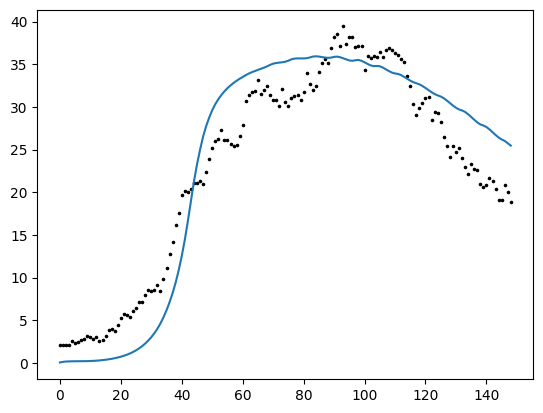

In [17]:
# b0, b1, t1, delta, k, h, p, gamma_h, mu_h, i0
pa1 = [1.68743304e+00, 6.85083158e-01, 4.21631243e+01, 3.74249832e-01,1.99869117e-01, 5.00255269e-02, 1.00089318e-01, 1.91951070e-01,1.01246515e-01, 9.98756731e+01]
pa2 = [1.72347533e+00, 7.36487471e-01, 4.52235894e+01, 2.87110856e-01,1.98750970e-01, 5.00752508e-02, 1.38152299e-01, 2.06237116e-01,1.02750520e-01, 9.91660146e+01]
pa3 = [1.90448872e+00, 7.88799430e-01, 4.20892093e+01, 3.08366736e-01,1.99983276e-01, 5.00094283e-02, 1.00004500e-01, 2.04036626e-01,1.01597373e-01, 9.99721425e+01]


par = [pa3]
delta_arr = []
k_arr = []
p_arr = []
gamma_h_arr = []
mu_h_arr = []
for i in [0]:
    b0, b1, t1, delta, k, h, p, gamma_h, mu_h, i0 = par[i]
    params =  b0, b1, t1, delta, k, h, p, gamma_h, mu_h
    sol = solve_ivp(fun = model_2020, t_span = [0, len(daily_cases_1)], args=(params,),
                        y0=[N-i0,0,0,0,0,0,i0,0,0,0,0,0,0,i0,0,0,0], t_eval = np.arange(len(daily_cases_1)))
    
    cases_cumu = np.cumsum(daily_cases_1)
    death_cumu = np.cumsum(daily_death_1)
    hosp_cumu = np.cumsum(daily_hosp_1)

    y_data = np.r_[cases_cumu]
    model_results = np.r_[sol.y[-4]]
    # plt.plot(np.arange(len(sol.y[-4])-1),np.diff(sol.y[-4]))
    # plt.scatter(np.arange(len(sol.y[-4])-1),np.diff(cases_cumu),s=2.5, color='k')
    plt.plot(np.arange(len(sol.y[-4])-1),np.diff(sol.y[-5]))
    plt.scatter(np.arange(len(sol.y[-4])-1),np.diff(death_cumu),s=2.5, color='k')
    # plt.plot(np.arange(len(sol.y[-4])-1),np.diff(sol.y[-3]))
    # plt.scatter(np.arange(len(sol.y[-4])-1),np.diff(hosp_cumu),s=2.5, color='k')

    err = -0.5 * np.sum(((y_data[:len(model_results)] - model_results)/0.05) ** 2)
    print(err)